# Supercenter Sales Analysis and Customer Segmentation
## Henry Siegler

The dataset in this analysis is one of the historical sales of a supermarket company in Myanmar that has recorded 3 months of sales data over 3 months. Each row of the dataset contains information for a single shopping run for a given customer, including information such as on who the customer is, the amount they spent, and what they rated their shopping experience.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import mysql.connector as mysql
from mysql.connector import MySQLConnection
from mysql.connector import Error

In [2]:
#read in the data
data = pd.read_csv('supermarket_sales.csv')
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


# Data Preprocessing

In [3]:
#changing the column names to be lowercase and have an underscore rather than a space

#create an array of the column names
columns = data.columns.values
#create an empty array to insert the new column names into
new_col_names = []

#replace the spaces in the column names with underscores and make them all lowercase
for column in columns:
    new_col_names.append(column.replace(' ', '_').lower())
    
#change % to percent
new_col_names[8] = 'tax_5_percent'
data.columns = new_col_names

data.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5_percent,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [4]:
#change the date column to datetime column type
data['date'] = pd.to_datetime(data['date'])
data['date'].head()

0   2019-01-05
1   2019-03-08
2   2019-03-03
3   2019-01-27
4   2019-02-08
Name: date, dtype: datetime64[ns]

# Creating SQL Database and Inserting Data

In [5]:
try:
    #connect to local instance of SQL server
    conn = mysql.connect(host='localhost', user='root',  
                        password='mypass')#give ur username, password
    if conn.is_connected():
        cursor = conn.cursor()
        #create supermarket database
        cursor.execute("""
                       DROP DATABASE IF EXISTS supermarketDB;
                       CREATE DATABASE supermarketDB;
                       """)
        print("Database is created")
except Error as e:
    print("Error while connecting to MySQL", e)

Database is created


In [6]:
try:
    conn = mysql.connect(host='localhost',
                           database='supermarketDB', user='root',
                           password='mypass')
    if conn.is_connected():
        cursor = conn.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)
        print('Creating table....')
        #create a table in the supermarket database with all of the columns in the dataframe using the correct data type
        cursor.execute("""
                       CREATE TABLE sales (
                           invoice_id CHAR(11) UNIQUE NOT NULL,
                           branch CHAR(1), 
                           city VARCHAR(25),
                           customer_type VARCHAR(25),
                           gender VARCHAR(25),
                           product_line VARCHAR(255),
                           unit_price DEC(4,2),
                           quantity INT,
                           tax_5_percent DEC(6, 4),
                           total DEC(8, 4), 
                           date DATE, 
                           time TIME, 
                           payment VARCHAR(25),
                           cogs DEC(5, 2),
                           gross_margin_percentage DEC(10, 4),
                           gross_income DEC(6, 4),
                           rating DEC(4, 2))
                        """
                      )
        print("Table is created...")
        #insert each row of the dataframe into the sql database
        for i, row in data.iterrows():
            sql = "INSERT INTO sales VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"
            cursor.execute(sql, tuple(row))
            # the connection is not autocommitted by default, so we must commit to save our changes
            conn.commit()
        print("Records have all been inserted")
except Error as e:
    print("Error while connecting to MySQL", e)

You're connected to database:  ('supermarketdb',)
Creating table....
Table is created...
Records have all been inserted


Now that the data has been inserted into the database, we will run a query.

In [7]:
#return the number of sales in each product category
query = """
SELECT 
    product_line, 
    COUNT(*) 
FROM sales
GROUP BY product_line;
"""
cursor.execute(query)
result = cursor.fetchall()

for i in result:
    print(i)

('Food and beverages', 174)
('Health and beauty', 152)
('Sports and travel', 166)
('Fashion accessories', 178)
('Home and lifestyle', 160)
('Electronic accessories', 170)


This returns a query in the form of a tuple, which is not easy to read.

### Creating a Function to Return Query in Dataframe

In [8]:
def sql_to_pandas(query):
    #execute the query
    cursor.execute(query)
    result = cursor.fetchall()
    
    #take out the column names from the query
    column_string = query[query.index('SELECT') + 7:query.index('FROM') - 1]
    #split the column names into an array
    columns = np.char.strip(column_string.split(","))
    #create a dataframe using the column names and values
    df = pd.DataFrame(result, columns = columns)
    return(df)

In [9]:
#return the number of sales in each product category
query = """
SELECT 
    product_line, 
    COUNT(*) 
FROM sales
GROUP BY product_line;
"""

sql_to_pandas(query)

,product_line,COUNT(*)
0,Food and beverages,174
1,Health and beauty,152
2,Sports and travel,166
3,Fashion accessories,178
4,Home and lifestyle,160
5,Electronic accessories,170


# Data Processing

In [10]:
missing_values = data.isnull().sum()
missing_values

invoice_id                 0
branch                     0
city                       0
customer_type              0
gender                     0
product_line               0
unit_price                 0
quantity                   0
tax_5_percent              0
total                      0
date                       0
time                       0
payment                    0
cogs                       0
gross_margin_percentage    0
gross_income               0
rating                     0
dtype: int64

There are no missing values in the entire dataset.

In [11]:
round(data.describe(), 2)

,unit_price,quantity,tax_5_percent,total,cogs,gross_margin_percentage,gross_income,rating
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,55.67,5.51,15.38,322.97,307.59,4.76,15.38,6.97
std,26.49,2.92,11.71,245.89,234.18,0.00,11.71,1.72
min,10.08,1.00,0.51,10.68,10.17,4.76,0.51,4.00
25%,32.88,3.00,5.92,124.42,118.50,4.76,5.92,5.50
50%,55.23,5.00,12.09,253.85,241.76,4.76,12.09,7.00
75%,77.94,8.00,22.45,471.35,448.90,4.76,22.45,8.50
max,99.96,10.00,49.65,1042.65,993.00,4.76,49.65,10.00


# Exploratory Data Analysis

## 1. How is total spending related to customer type and gender?

In [12]:
query = """
SELECT 
    customer_type, 
    AVG(total) 
FROM sales
GROUP BY customer_type;
"""

#average total amount spent by normal and member customers
sql_to_pandas(query)

,customer_type,AVG(total)
0,Normal,318.12285571
1,Member,327.79130539


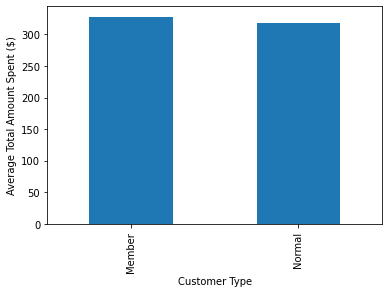

In [13]:
df = data.groupby('customer_type')['total'].mean()
df.plot(kind = 'bar')
plt.ylabel('Average Total Amount Spent ($)')
plt.xlabel("Customer Type")
plt.show()

In [14]:
query = """
SELECT 
    gender, 
    AVG(total) 
FROM sales
GROUP BY gender;
"""

#average total amount spent by gender
sql_to_pandas(query)

,gender,AVG(total)
0,Male,310.78922645
1,Female,335.09565868


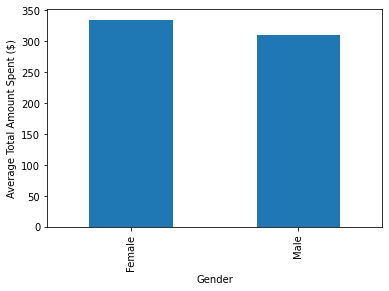

In [15]:
df = data.groupby('gender')['total'].mean()
df.plot(kind = 'bar')
plt.ylabel('Average Total Amount Spent ($)')
plt.xlabel('Gender')
plt.show()

In [16]:
query = """
SELECT 
    gender,
    customer_type,
    AVG(total) 
FROM sales
GROUP BY gender, customer_type
ORDER BY AVG(total) DESC;
"""

#average total amount spent by each gender and customer type combination
sql_to_pandas(query)

,gender,customer_type,AVG(total)
0,Female,Member,337.72775287
1,Female,Normal,332.23325625
2,Male,Member,316.98541875
3,Male,Normal,305.04758108


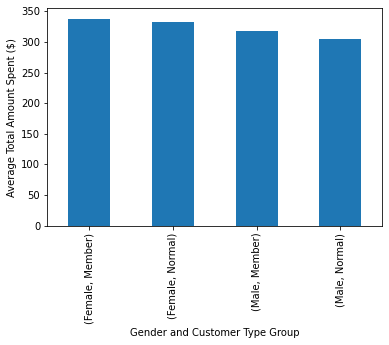

In [17]:
df = data.groupby(['gender', 'customer_type'])['total'].mean()
df.plot(kind = 'bar')
plt.ylabel('Average Total Amount Spent ($)')
plt.xlabel('Gender and Customer Type Group')
plt.show()

Members generally spend slightly more than normal customers on average, however the difference in average spending is greater between males and females, as females spend \\$25 more than males on average. When we look at the combinations of gender and customer type, we can see that female members are the group that spend the most on average, with an average total of \\$337, compared to an average total of \\$305 for male non-members.

## 2. Which product category generates the highest income?

In [18]:
query = """
SELECT 
    product_line,
    COUNT(*)
FROM sales
GROUP BY product_line
ORDER BY COUNT(*) DESC;
"""

#number of shopping runs in each general item categorization group
sql_to_pandas(query)

,product_line,COUNT(*)
0,Fashion accessories,178
1,Food and beverages,174
2,Electronic accessories,170
3,Sports and travel,166
4,Home and lifestyle,160
5,Health and beauty,152


In [19]:
query = """
SELECT 
    product_line,
    AVG(total)
FROM sales
GROUP BY product_line
ORDER BY AVG(total) DESC;
"""

#average total amount spent by each of the product line categorizations
sql_to_pandas(query)

,product_line,AVG(total)
0,Home and lifestyle,336.63695625
1,Sports and travel,332.06521988
2,Health and beauty,323.64301974
3,Food and beverages,322.67151724
4,Electronic accessories,319.63253824
5,Fashion accessories,305.08929775


Most supermarket sales are categorized in the 'Fashion accessories' group with 178 purchases being categorized in this group. However, the fashion accessories category group has the smallest average total amount spent by customers out of all of the groups, which means that the supermarket is not making as much money off of these types of transactions (because cost of goods sold is constant for all items). So, while fasion accessories are the most common category for people to buy, the total purchase amount is generally the smallest.

In [20]:
query = """
SELECT 
    product_line,
    SUM(total)
FROM sales
GROUP BY product_line
ORDER BY SUM(total) DESC;
"""

#total amount spent in each of the product categories
sql_to_pandas(query)

,product_line,SUM(total)
0,Food and beverages,56144.8440
1,Sports and travel,55122.8265
2,Electronic accessories,54337.5315
3,Fashion accessories,54305.8950
4,Home and lifestyle,53861.9130
5,Health and beauty,49193.7390


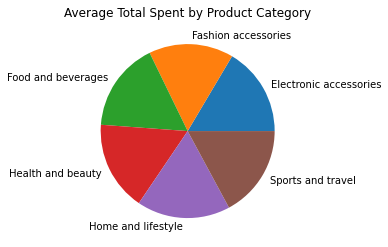

In [21]:
data.groupby('product_line')['total'].mean().plot(kind='pie')
plt.title("Average Total Spent by Product Category")
plt.ylabel("")
plt.show()

Overall, 'Food and beverages' is the group of purchases that results in the highest overall total amount spent (and income). However, 'Home and lifestyle' shopping runs are associated with the highest average total price.

# 3. What is the total sales for each gender and product category combination?

In [22]:
query = """
SELECT 
    product_line,
    gender,
    SUM(total)
FROM sales
GROUP BY product_line, gender
ORDER BY SUM(total) DESC;
"""

#total amount spent in each product category and gender combination
sql_to_pandas(query)

,product_line,gender,SUM(total)
0,Food and beverages,Female,33170.9175
1,Health and beauty,Male,30632.7525
2,Fashion accessories,Female,30437.4000
3,Home and lifestyle,Female,30036.8775
4,Sports and travel,Female,28574.7210
5,Electronic accessories,Male,27235.5090
6,Electronic accessories,Female,27102.0225
7,Sports and travel,Male,26548.1055
8,Fashion accessories,Male,23868.4950
9,Home and lifestyle,Male,23825.0355


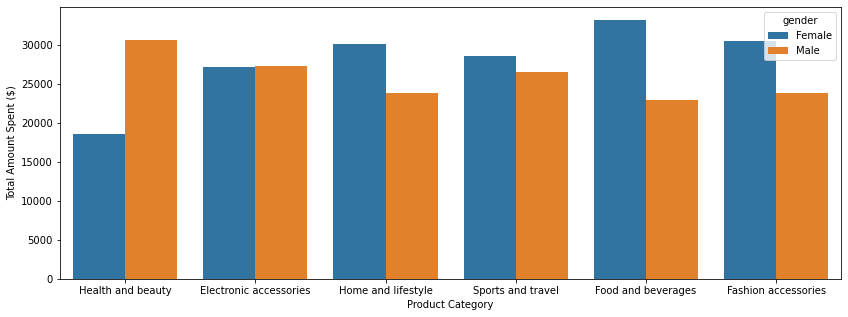

In [23]:
plt.figure(figsize=(14,5))
sns.barplot(x='product_line', y = 'total', hue = 'gender', data = data, estimator = sum, ci = None)
plt.xlabel('Product Category')
plt.ylabel('Total Amount Spent ($)')
plt.show()

The gender and product category responsible for the highest total amount spent is females for food and beverages with \\$33,170 spent. However, the male spending in food and beverages is the second to lowest category with only \\$22,900 spent.

The highest product category for males in terms of total amount spent was 'Health and beauty' at \\$30,600. However, females only spent \\$18,500 in 'Health and beauty'. This demonstrates that males and females have very different spending habits in terms of what they are purchasing.

## 4. How is customer rating related to product category?

In [24]:
query = """
SELECT 
    product_line,
    AVG(rating),
    SUM(total)
FROM sales
GROUP BY product_line
ORDER BY AVG(rating) DESC;
"""

#average customer rating by product category
sql_to_pandas(query)

,product_line,AVG(rating),SUM(total)
0,Food and beverages,7.113218,56144.8440
1,Fashion accessories,7.029213,54305.8950
2,Health and beauty,7.003289,49193.7390
3,Electronic accessories,6.924706,54337.5315
4,Sports and travel,6.916265,55122.8265
5,Home and lifestyle,6.837500,53861.9130


Food and beverages purchases, which is the category responsible for the most profit, have the highest average rating too.

In [25]:
query = """
SELECT 
    product_line,
    gender,
    AVG(rating)
FROM sales
GROUP BY product_line, gender
ORDER BY AVG(rating) DESC;
"""

#average customer rating by each gender and product category combination
sql_to_pandas(query)

,product_line,gender,AVG(rating)
0,Food and beverages,Female,7.203333
1,Health and beauty,Female,7.146875
2,Fashion accessories,Female,7.120833
3,Sports and travel,Male,7.084615
4,Electronic accessories,Male,7.059302
5,Food and beverages,Male,7.016667
6,Fashion accessories,Male,6.921951
7,Home and lifestyle,Male,6.909877
8,Health and beauty,Male,6.898864
9,Electronic accessories,Female,6.786905


There is no combination of gender and product category that greatly stands out from the others in terms of average rating. We do notice that the female categories have both the highest and lowest average ratings for the product categories.

## 5. How is each of the 3 locations of supercenters performing?

In [26]:
query = """
SELECT 
    city,
    COUNT(*)
FROM sales
GROUP BY city;
"""

#number of shopping runs at each of the 3 cities
sql_to_pandas(query)

,city,COUNT(*)
0,Yangon,340
1,Naypyitaw,328
2,Mandalay,332


Since there are different numbers of observations in the dataset for the three locations of the supercenters, we will analyze the average of various metrics for the cities, rather than their totals.

In [27]:
#create a view with customer type as a binary variable
query = """
CREATE OR REPLACE VIEW member_one as
SELECT 
    invoice_id as id,
    case
        when customer_type = 'Member' then 1
        else 0
    end as member
FROM sales;
"""

cursor.execute(query)

In [28]:
#join this query with the view created in the previous code chunk
query = """
SELECT 
    city,
    AVG(member) * 100, 
    AVG(rating), 
    AVG(gross_income)
FROM sales
LEFT JOIN member_one ON member_one.id = sales.invoice_id
GROUP BY city
ORDER BY AVG(rating) DESC;
"""

#find average membership rates, rating, and gross income by each city
sql_to_pandas(query)

,city,AVG(member) * 100,AVG(rating),AVG(gross_income)
0,Naypyitaw,51.5244,7.072866,16.05236738
1,Yangon,49.1176,7.027059,14.87400147
2,Mandalay,49.6988,6.818072,15.23202410


The supercenter location in Naypyitaw is performing better that the other 2 locations in terms of percentage of purchases by members, average rating, and total gross income. 

In [29]:
query = """
SELECT 
    city, 
    product_line,
    SUM(gross_income),
    COUNT(*),
    AVG(gross_income)
FROM sales
GROUP BY city, product_line
ORDER BY city, AVG(gross_income) DESC;
"""

#average gross income for each city and product category combination
sql_to_pandas(query)

,city,product_line,SUM(gross_income),COUNT(*),AVG(gross_income)
0,Mandalay,Health and beauty,951.4600,53,17.95207547
1,Mandalay,Home and lifestyle,835.6745,50,16.71349000
2,Mandalay,Sports and travel,951.8190,62,15.35191935
3,Mandalay,Electronic accessories,811.9735,55,14.76315455
4,Mandalay,Food and beverages,724.5185,50,14.49037000
5,Mandalay,Fashion accessories,781.5865,62,12.60623387
6,Naypyitaw,Food and beverages,1131.7550,66,17.14780303
7,Naypyitaw,Sports and travel,750.5680,45,16.67928889
8,Naypyitaw,Electronic accessories,903.2845,55,16.42335455
9,Naypyitaw,Fashion accessories,1026.6700,65,15.79492308


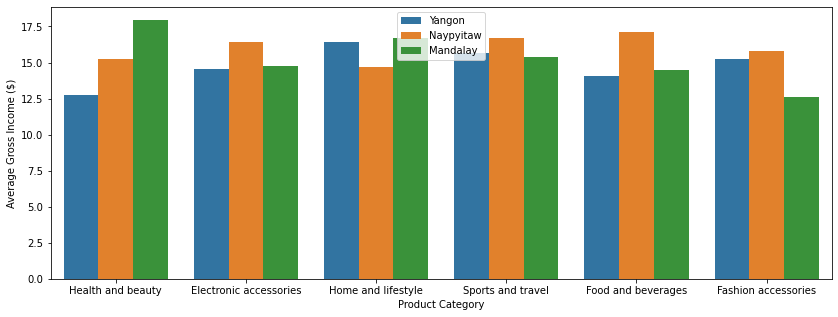

In [30]:
plt.figure(figsize=(14,5))
sns.barplot(x='product_line', y = 'gross_income', hue = 'city', data = data, estimator = np.average, ci = None)
plt.xlabel('Product Category')
plt.ylabel('Average Gross Income ($)')
plt.legend(loc = 'upper center')
plt.show()

The supercenter location in Naypyitaw has the highest average gross incomes for most types of shopping runs. It has a significantly higher average gross income for food and beverages shopping runs, which is driving its profits.

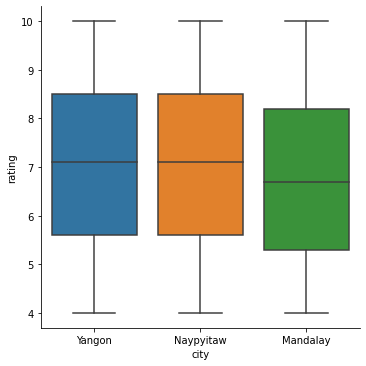

In [31]:
sns.catplot(x = 'city', y='rating', kind='box',data=data)
plt.show()

The location in Mandalay does have a lower median customer rating compared to the other locations, which could be a reason for its poor performance.

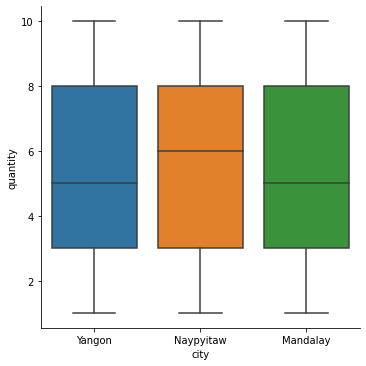

In [32]:
sns.catplot(x = 'city', y='quantity', kind='box',data=data)
plt.show()

Customers at the supercenter in Naypyitaw generally purchase more items on their runs relative to the other locations. This could be a contributing factor to the success at the Naypyitaw location.

## 6. How has the average total amount spent changed over this three month period?

In [33]:
query = """
SELECT 
    date,
    COUNT(*)
FROM sales
GROUP BY date
ORDER BY COUNT(*);
"""

#number of observations on each date
sql_to_pandas(query)

,date,COUNT(*)
0,2019-01-04,6
1,2019-02-01,6
2,2019-03-17,6
3,2019-02-21,6
4,2019-02-28,6
...,...,...
84,2019-01-08,18
85,2019-03-14,18
86,2019-03-02,18
87,2019-02-15,19


There are different numbers of customers that shopped at the supercenters on each day. However, the observations are not likely just a small portion of the total number of customers at the supercenters on each day, so we will look at averages of the metrics over time rather than the totals.

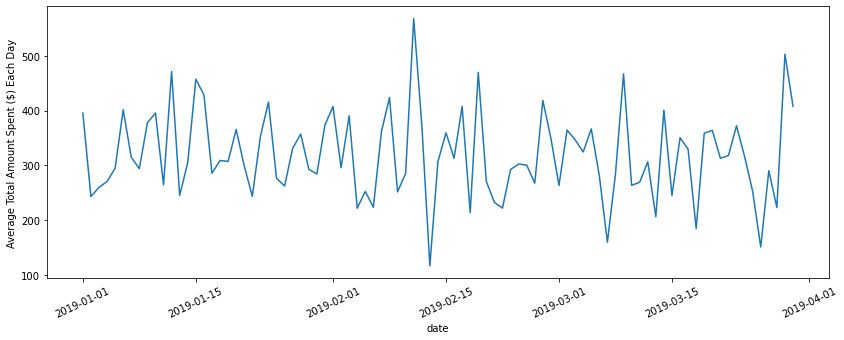

In [34]:
plt.figure(figsize=(14,5))
#group the data by the date and find the average total spent
data.groupby(data['date'].dt.date)["total"].mean().plot(kind="line", rot=25, )
plt.ylabel("Average Total Amount Spent ($) Each Day")
plt.show()

We see a very large spike and drop average total amount spent in February, which we will zoom in and focus on.

In [35]:
#create a dataframe for only February data
feb_data = data[data.date.dt.month == 2]

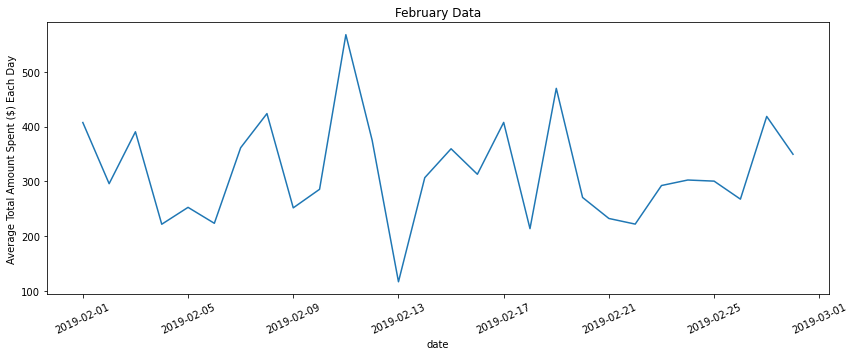

In [36]:
plt.figure(figsize=(14,5))
##group the data by the date and find the average total spent
feb_data.groupby(feb_data['date'].dt.date)["total"].mean().plot(kind="line", rot=25, )
plt.ylabel("Average Total Amount Spent ($) Each Day")
plt.title("February Data")
plt.show()

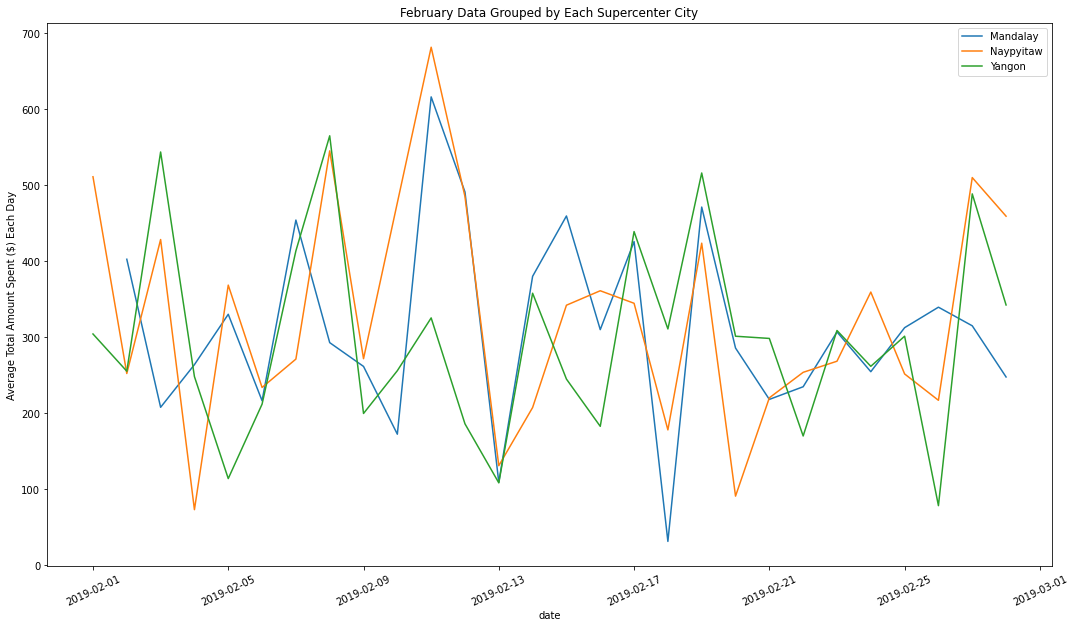

In [37]:
plt.figure(figsize=(18,10))
#filter the data by each city and find the respective average total amount spent for each city
feb_data.loc[data['city'] == "Mandalay"].groupby(feb_data['date'].dt.date)["total"].mean().plot(kind="line", rot=25)
feb_data.loc[data['city'] == "Naypyitaw"].groupby(feb_data['date'].dt.date)["total"].mean().plot(kind="line", rot=25)
feb_data.loc[data['city'] == "Yangon"].groupby(feb_data['date'].dt.date)["total"].mean().plot(kind="line", rot=25)
legend_drawn_flag = True
#create the legend
plt.legend(["Mandalay", "Naypyitaw", "Yangon"], loc=0, frameon=legend_drawn_flag)
plt.ylabel("Average Total Amount Spent ($) Each Day")
plt.title("February Data Grouped by Each Supercenter City")
plt.show()

When we look at the average total amount spent by customers by each location, we can see that the low average on February 13 is not unsually low, as all of the supercenter locations had values that low on other dates. The high average total amount spent on February 11 does seem to be unusually high for two of the locations since there are no other values that were that high for any of the locations. This indicates that there could be some reason why there

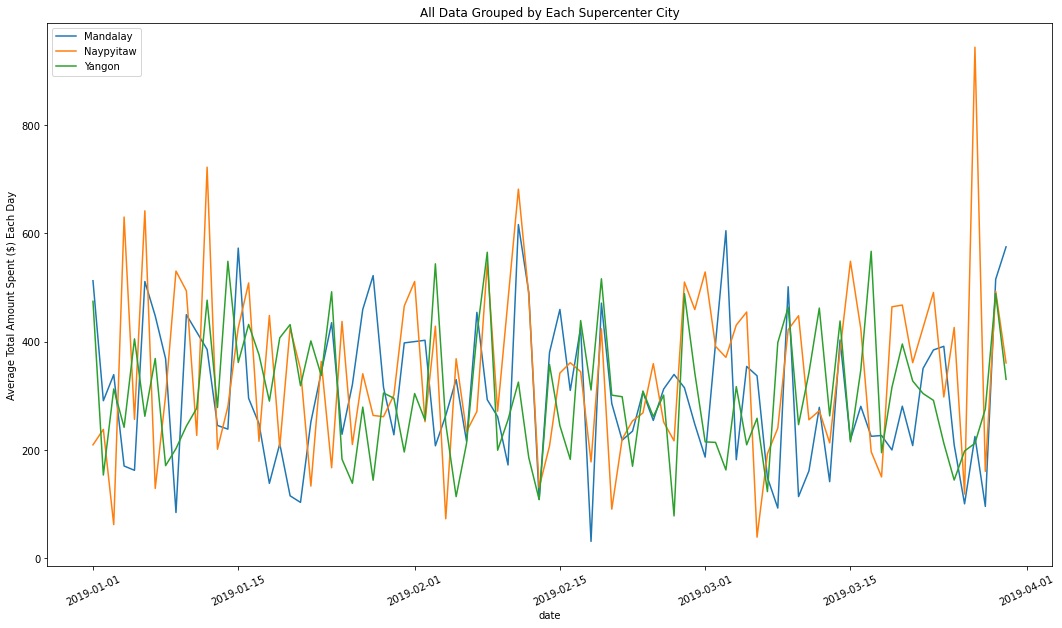

In [38]:
plt.figure(figsize=(18,10))
#filter the data by each city and find the respective average total amount spent for each city
data.loc[data['city'] == "Mandalay"].groupby(data['date'].dt.date)["total"].mean().plot(kind="line", rot=25)
data.loc[data['city'] == "Naypyitaw"].groupby(data['date'].dt.date)["total"].mean().plot(kind="line", rot=25)
data.loc[data['city'] == "Yangon"].groupby(data['date'].dt.date)["total"].mean().plot(kind="line", rot=25)
legend_drawn_flag = True
plt.legend(["Mandalay", "Naypyitaw", "Yangon"], loc=0, frameon=legend_drawn_flag)
plt.ylabel("Average Total Amount Spent ($) Each Day")
plt.title("All Data Grouped by Each Supercenter City")
plt.show()

If we zoom out to the full timeframe of the data, the high average total amount spent on February 11 does not appear to be that unusual, since Naypyitaw has several days with average values that high. However, there is one day at the end of March that appears to have a very high average total amount spent in the Naypyitaw location.

In [39]:
query = """
SELECT
    date,
    city,
    AVG(total),
    COUNT(*)
FROM sales 
WHERE city LIKE 'Naypyitaw'
GROUP BY date, city
ORDER BY AVG(total) DESC
LIMIT 10;
"""

#find the highest average total amount spent on each date at the Naypyitaw location
sql_to_pandas(query)

,date,city,AVG(total),COUNT(*)
0,2019-03-27,Naypyitaw,943.29900000,1
1,2019-01-12,Naypyitaw,721.79100000,2
2,2019-02-11,Naypyitaw,681.32750000,3
3,2019-01-06,Naypyitaw,641.29800000,2
4,2019-01-04,Naypyitaw,629.84250000,1
5,2019-03-15,Naypyitaw,548.18400000,1
6,2019-02-08,Naypyitaw,544.95000000,3
7,2019-01-09,Naypyitaw,530.09670000,5
8,2019-03-01,Naypyitaw,528.41775000,2
9,2019-02-01,Naypyitaw,510.86700000,3


The reason why the average total amount spent was so high in Naypyitaw for the day at the end of March was so high was because there was only one observation on that day and location, which happened to be unsuually large.

Also, we can see that each unique day and location only have a few observations each, so we should probably not look to far into these statistics due to a small sample size.

## 7. Are there any patterns in the data related to time of day?

In [40]:
#change the time column to datetime column type
data['time'] = pd.to_datetime(data['time'])
#create an hour column using the hour from the time column
data['hour'] = data['time'].dt.hour

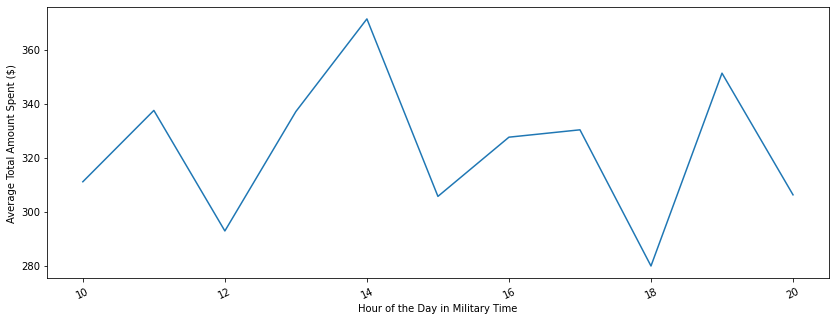

In [41]:
plt.figure(figsize=(14,5))
data.groupby(data['hour'])["total"].mean().plot(kind="line", rot=25)
plt.ylabel("Average Total Amount Spent ($)")
plt.xlabel('Hour of the Day in Military Time')
plt.show()

The average amount spent on a shopping run is highest around 1 to 2 PM and hit its lowest at 6 PM. However, the average amount spent remains relatively steady throughout the day.

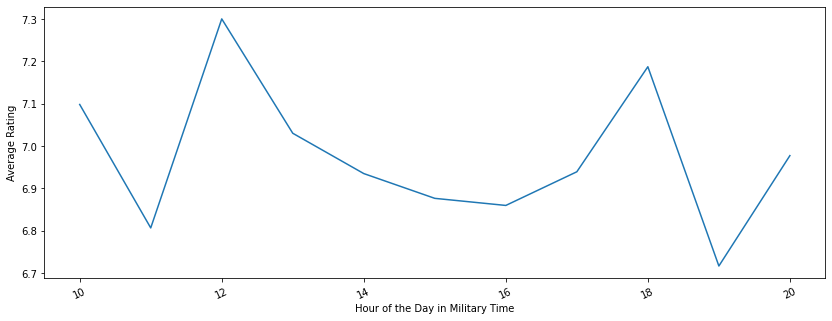

In [42]:
plt.figure(figsize=(14,5))
data.groupby(data['hour'])["rating"].mean().plot(kind="line", rot=25)
plt.ylabel("Average Rating")
plt.xlabel('Hour of the Day in Military Time')
plt.show()

Average ratings seem to drop mid-day, around 1 PM to 5 PM.

## 8. What group types do the customers fall into?

In [43]:
query = """
SELECT
    gender,
    customer_type,
    product_line,
    city,
    AVG(rating),
    COUNT(*)
FROM sales
GROUP BY
    gender,
    customer_type,
    product_line,
    city
ORDER BY AVG(rating) DESC
LIMIT 10;
"""

#10 groups with highest average ratings
sql_to_pandas(query)

,gender,customer_type,product_line,city,AVG(rating),COUNT(*)
0,Male,Normal,Sports and travel,Naypyitaw,8.066667,3
1,Female,Member,Health and beauty,Mandalay,8.014286,7
2,Female,Member,Fashion accessories,Naypyitaw,7.926316,19
3,Male,Normal,Home and lifestyle,Yangon,7.913333,15
4,Male,Member,Sports and travel,Yangon,7.863636,11
5,Male,Normal,Food and beverages,Yangon,7.793750,16
6,Female,Normal,Food and beverages,Naypyitaw,7.680000,15
7,Female,Normal,Food and beverages,Mandalay,7.663636,11
8,Male,Member,Electronic accessories,Yangon,7.552632,19
9,Female,Normal,Health and beauty,Yangon,7.522222,9


In [44]:
query = """
SELECT
    gender,
    customer_type,
    product_line,
    city,
    AVG(rating),
    COUNT(*)
FROM sales
GROUP BY
    gender,
    customer_type,
    product_line,
    city
ORDER BY AVG(rating)
LIMIT 10;
"""

#10 groups with lowest average ratings
sql_to_pandas(query)

,gender,customer_type,product_line,city,AVG(rating),COUNT(*)
0,Female,Normal,Home and lifestyle,Mandalay,5.790000,10
1,Male,Member,Home and lifestyle,Mandalay,6.044444,9
2,Male,Member,Sports and travel,Mandalay,6.075000,12
3,Male,Member,Electronic accessories,Naypyitaw,6.109091,11
4,Male,Normal,Food and beverages,Mandalay,6.170000,10
5,Female,Member,Sports and travel,Mandalay,6.211111,18
6,Female,Normal,Electronic accessories,Yangon,6.225000,16
7,Female,Normal,Home and lifestyle,Yangon,6.281250,16
8,Male,Normal,Health and beauty,Yangon,6.412500,16
9,Female,Member,Electronic accessories,Yangon,6.416667,12


In [45]:
data['rating'].describe()

count    1000.00000
mean        6.97270
std         1.71858
min         4.00000
25%         5.50000
50%         7.00000
75%         8.50000
max        10.00000
Name: rating, dtype: float64

Since the standard deviation of rating is 1.71, the difference between the average ratings of the highest and lowest groups is significant. The highest average rating is 8.06 and the lowest average rating is 5.79, which the supercenters should look into.

The home and lifestyle purchase categories in Mandalay for example have very low average ratings for some combinations of gender and customer type. 

## Customer Segmentation via Clustering

We will now perform a clustering algorithm on the dataset to identify different groups of customers at these supercenters, which may provide more insight into the types of customers that shop at the supercenters and what their spending habits and characteristics are. We may find many distinct different groups of customers, or we may find that customers are generally pretty similar and fall into only a couple of different clusters.

In [46]:
#create an array of the names of the columns of the categorical variables
categorical_cols = ['city', 'gender','product_line', 'customer_type', 'payment']

#create dataframe with the categorical variables one hot coded
encoded_df = pd.get_dummies(data, columns = categorical_cols)
encoded_df.head()

,invoice_id,branch,unit_price,quantity,tax_5_percent,total,date,time,cogs,gross_margin_percentage,...,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,customer_type_Member,customer_type_Normal,payment_Cash,payment_Credit card,payment_Ewallet
0,750-67-8428,A,74.69,7,26.1415,548.9715,2019-01-05,2023-01-10 13:08:00,522.83,4.761905,...,0,0,1,0,0,1,0,0,0,1
1,226-31-3081,C,15.28,5,3.8200,80.2200,2019-03-08,2023-01-10 10:29:00,76.40,4.761905,...,0,0,0,0,0,0,1,1,0,0
2,631-41-3108,A,46.33,7,16.2155,340.5255,2019-03-03,2023-01-10 13:23:00,324.31,4.761905,...,0,0,0,1,0,0,1,0,1,0
3,123-19-1176,A,58.22,8,23.2880,489.0480,2019-01-27,2023-01-10 20:33:00,465.76,4.761905,...,0,0,1,0,0,1,0,0,0,1
4,373-73-7910,A,86.31,7,30.2085,634.3785,2019-02-08,2023-01-10 10:37:00,604.17,4.761905,...,0,0,0,0,1,0,1,0,0,1


In [47]:
#names of all of the columns
encoded_df.columns.values

array(['invoice_id', 'branch', 'unit_price', 'quantity', 'tax_5_percent',
       'total', 'date', 'time', 'cogs', 'gross_margin_percentage',
       'gross_income', 'rating', 'hour', 'city_Mandalay',
       'city_Naypyitaw', 'city_Yangon', 'gender_Female', 'gender_Male',
       'product_line_Electronic accessories',
       'product_line_Fashion accessories',
       'product_line_Food and beverages',
       'product_line_Health and beauty',
       'product_line_Home and lifestyle',
       'product_line_Sports and travel', 'customer_type_Member',
       'customer_type_Normal', 'payment_Cash', 'payment_Credit card',
       'payment_Ewallet'], dtype=object)

In [48]:
#drop the columns in the encoded dataframe that do not contribute to the k means clustering algorithm
#dropping a one hot encoded column is generally not necessary for k means clustering
encoded_df = encoded_df.drop(['invoice_id', 'branch', 'date', 'time'], axis=1)

encoded_df.head()

,unit_price,quantity,tax_5_percent,total,cogs,gross_margin_percentage,gross_income,rating,hour,city_Mandalay,...,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,customer_type_Member,customer_type_Normal,payment_Cash,payment_Credit card,payment_Ewallet
0,74.69,7,26.1415,548.9715,522.83,4.761905,26.1415,9.1,13,0,...,0,0,1,0,0,1,0,0,0,1
1,15.28,5,3.8200,80.2200,76.40,4.761905,3.8200,9.6,10,0,...,0,0,0,0,0,0,1,1,0,0
2,46.33,7,16.2155,340.5255,324.31,4.761905,16.2155,7.4,13,0,...,0,0,0,1,0,0,1,0,1,0
3,58.22,8,23.2880,489.0480,465.76,4.761905,23.2880,8.4,20,0,...,0,0,1,0,0,1,0,0,0,1
4,86.31,7,30.2085,634.3785,604.17,4.761905,30.2085,5.3,10,0,...,0,0,0,0,1,0,1,0,0,1


In [49]:
#scale all of the columns that were not one hot coded
numeric_df = encoded_df.iloc[:, 0:9]

#create an array of the column names
column_names = numeric_df.columns.values

#scale the dataframe so that the mean of each column is 0 and the variance is 1
#this improves the performance of the clustering algorithm to create different customer types
scaler = StandardScaler().fit(numeric_df.values)
features = scaler.transform(numeric_df.values)
scaled_features = pd.DataFrame(features, columns = column_names)
scaled_features.head()

,unit_price,quantity,tax_5_percent,total,cogs,gross_margin_percentage,gross_income,rating,hour
0,0.718160,0.509930,0.919607,0.919607,0.919607,0.0,0.919607,1.238443,-0.599637
1,-1.525303,-0.174540,-0.987730,-0.987730,-0.987730,0.0,-0.987730,1.529527,-1.541474
2,-0.352781,0.509930,0.071446,0.071446,0.071446,0.0,0.071446,0.248760,-0.599637
3,0.096214,0.852165,0.675780,0.675780,0.675780,0.0,0.675780,0.830927,1.597984
4,1.156959,0.509930,1.267125,1.267125,1.267125,0.0,1.267125,-0.973790,-1.541474


In [50]:
#take out the one hot coded columns
encoded_vars = encoded_df.iloc[:, 9:]
encoded_vars.head()

,city_Mandalay,city_Naypyitaw,city_Yangon,gender_Female,gender_Male,product_line_Electronic accessories,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,customer_type_Member,customer_type_Normal,payment_Cash,payment_Credit card,payment_Ewallet
0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1
1,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0
3,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1
4,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1


In [51]:
#join the scaled dataframe with the one hot coded dataframe
new_df = scaled_features.join(encoded_vars)
new_df.head()

,unit_price,quantity,tax_5_percent,total,cogs,gross_margin_percentage,gross_income,rating,hour,city_Mandalay,...,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,customer_type_Member,customer_type_Normal,payment_Cash,payment_Credit card,payment_Ewallet
0,0.718160,0.509930,0.919607,0.919607,0.919607,0.0,0.919607,1.238443,-0.599637,0,...,0,0,1,0,0,1,0,0,0,1
1,-1.525303,-0.174540,-0.987730,-0.987730,-0.987730,0.0,-0.987730,1.529527,-1.541474,0,...,0,0,0,0,0,0,1,1,0,0
2,-0.352781,0.509930,0.071446,0.071446,0.071446,0.0,0.071446,0.248760,-0.599637,0,...,0,0,0,1,0,0,1,0,1,0
3,0.096214,0.852165,0.675780,0.675780,0.675780,0.0,0.675780,0.830927,1.597984,0,...,0,0,1,0,0,1,0,0,0,1
4,1.156959,0.509930,1.267125,1.267125,1.267125,0.0,1.267125,-0.973790,-1.541474,0,...,0,0,0,0,1,0,1,0,0,1


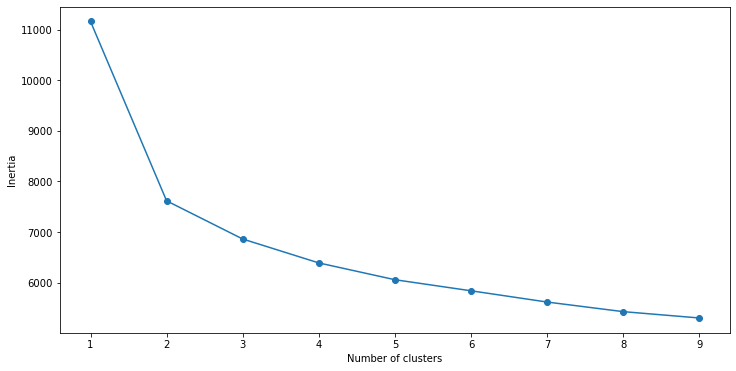

In [52]:
import random

#run the k means algorithm on the dataframe using clusters ranging from 1 to 10
SSE = []
for cluster in range(1,10):
    random.seed(15)
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(new_df)
    #save the inertia or SSE from each k means cluster to an array
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})

#plot the inertia values of SSE for each of different number of clusters
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Inertia measures how accurately the dataset was clustered by the K-Means clustering algorithm. Inertia is calculated by summing the squared distances of each point and its cluster centroid. So smaller intertia values are "better". If we see a large drop in the intertia value when we increase the number of clusters by 1, it suggests that the increase in the number of clusters is explaining the clusters in the data well.

The drop in the inertia value moving from 1 cluster to 2 clusters is very significant, but as the number of clusters increases from there, the drop in inertia is not as significant. This graph suggests that the optimal number of clusters to use is 2 clusters.

In [53]:
random.seed(15)
#cluster the data using 2 clusters
kmeans = KMeans(n_clusters = 2, init='k-means++')
kmeans.fit(new_df)

# Now, print the silhouette score of this model using 2 clusters

print(silhouette_score(new_df, kmeans.labels_, metric='euclidean'))

0.2780526853434047


Silhouette coefficients are a metric used to test the quality of the clusters, with values ranging from -1 to +1. Higher silhouette scores are better.

This model with 2 clusters has a silhouette coefficient of 0.27, which is a fairly high score.

### PCA

There are many features or columns in the dataset, so we will try Principal Component Analysis (PCA) to reduce the dimensions 
of the dataset and see if it improves the quality of our clusters.

To find the number of components we will use, we will find out of the number of components needed to reach a threshold of explained variance of 80%.

In [54]:
#create a PCA instance using 10 PCA components
pca = PCA(n_components=10)
#run the PCA algorithm on the dataframe
principalComponents = pca.fit_transform(new_df)

#create a dataframe of the 
PCA_components = pd.DataFrame(principalComponents)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
variance_df = pd.DataFrame({'Components':range(1,11), 'cumulative_variance':cumulative_variance})
variance_df

,Components,cumulative_variance
0,1,0.441036
1,2,0.534211
2,3,0.623786
3,4,0.710463
4,5,0.757503
5,6,0.800140
6,7,0.831749
7,8,0.861811
8,9,0.890664
9,10,0.918586


It takes 6 components to reach a cumulative sum of explained variance of 80%, so we will use 6 components.

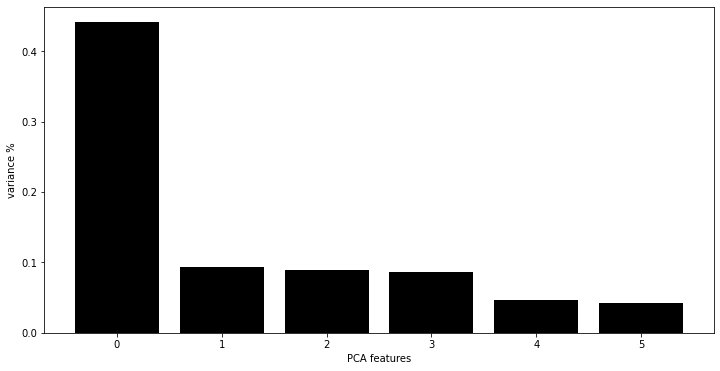

In [55]:
#create a PCA instance using 10 PCA components
pca = PCA(n_components=6)
#run the PCA algorithm on the dataframe
principalComponents = pca.fit_transform(new_df)

#create a dataframe of the 
PCA_components = pd.DataFrame(principalComponents)

features = range(pca.n_components_)

#plot the explained variance from each of the 6 PCA components
plt.figure(figsize=(12,6))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

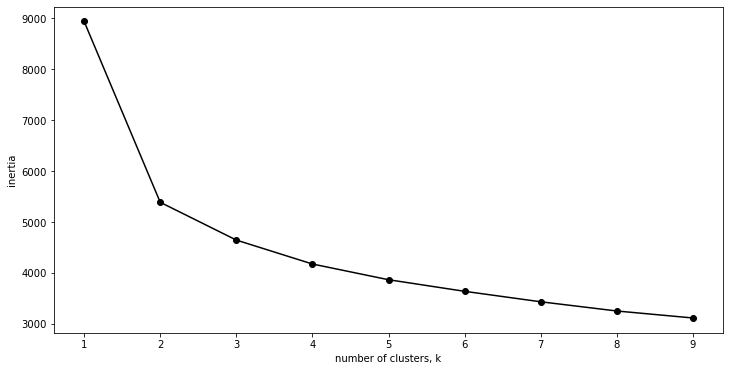

In [56]:
#create an array on different numbers of ks to use for the k means algorithm
ks = range(1, 10)
inertias = []

#find the inertia or SSE values using different numbers of ks in the k means algorithm on the PCA dataset
random.seed(15)
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components)
    inertias.append(model.inertia_)

plt.figure(figsize=(12,6))
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Based on this graph, it still looks like the ideal number of clusters is still 2.

In [57]:
random.seed(15)
model = KMeans(n_clusters=2)
model.fit(PCA_components.iloc[:,:6])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean')) 

0.5119347936527996


Silhouette scores range from -1 to 1, where a high value indicates that a customer is well matched to their cluster.

The silhouette score of 0.51 is significantly higher than the previous score of 0.27, and this high score suggests that 2 clusters after using PCA is a good clustering solution.

### Cluster Analysis

In [58]:
#add the predicted cluster as a column in the dataset
pred = model.predict(PCA_components)

#add a column to the original dataframe showing which cluster they belong to
encoded_df['cluster'] = pred
#change 0s to 1s and 1s to 2s
encoded_df['cluster'] = encoded_df['cluster'].replace({0:1, 1:2})

In [59]:
#find the average of all the variable across each cluster
avg_df = encoded_df.groupby(['cluster']).mean()
avg_df

,unit_price,quantity,tax_5_percent,total,cogs,gross_margin_percentage,gross_income,rating,hour,city_Mandalay,...,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,customer_type_Member,customer_type_Normal,payment_Cash,payment_Credit card,payment_Ewallet
cluster,,,,,,,,,,,,,,,,,,,,,
1,45.297447,4.325826,8.307023,174.447473,166.140450,4.761905,8.307023,7.000300,14.893393,0.334835,...,0.178679,0.181682,0.154655,0.159159,0.159159,0.492492,0.507508,0.345345,0.312312,0.342342
2,76.359371,7.871257,29.481713,619.115964,589.634251,4.761905,29.481713,6.917665,14.943114,0.326347,...,0.176647,0.158683,0.146707,0.161677,0.179641,0.517964,0.482036,0.341317,0.308383,0.350299


In [60]:
encoded_df.groupby(['cluster']).count().iloc[:,1]

cluster
1    666
2    334
Name: quantity, dtype: int64

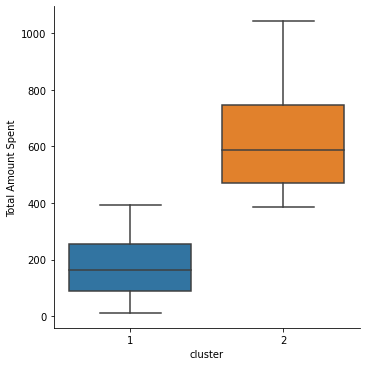

In [61]:
sns.catplot(x = 'cluster', y='total', kind='box',data=encoded_df)
plt.ylabel("Total Amount Spent")
plt.show()

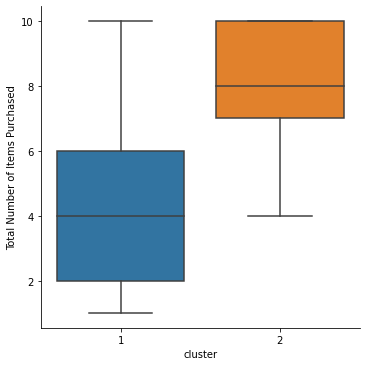

In [62]:
sns.catplot(x = 'cluster', y='quantity', kind='box',data=encoded_df)
plt.ylabel("Total Number of Items Purchased")
plt.show()

In the dataframe above, we can see that the largest differences between the 2 clusters is their spending amounts, rather than the city, gender, product line, member type, or type of payment.

There are 666 customers in cluster 1 and 334 customers in cluster 2.

Cluster 1: Generally spends less overall, buys fewer items, and the items themselves are cheaper items.

Cluster 2: These people generally spend much more in total, buy more items, and the items are more expensive by the unit.

We can see that there are two very distinct groups of customers in terms of spending amounts and quantiy, based on the boxplots. There is no overlap in the boxplots between cluster 1 and 2 for both total amount spent and the number of items purchased in a shopping run. 

### Using 4 Clusters

Looking at the intertia value graph, 2 clusters is clear number of clusters to use, however we will still look into using more clusters.

In [63]:
random.seed(15)
#run a k means clustering algorithm on the PCA dataset using 4 clusters
model = KMeans(n_clusters=4)
model.fit(PCA_components)

#predict the cluster of each customer
pred = model.predict(PCA_components)

#add the cluster results to the dataframe
encoded_df['cluster'] = pred
encoded_df['cluster'] = encoded_df['cluster'].replace({0:1, 1:2, 2:3, 3:4})

#find the average value by each cluster
avg_df = encoded_df.groupby(['cluster']).mean()

#averages of the numeric columns
avg_df.iloc[:,:9]

,unit_price,quantity,tax_5_percent,total,cogs,gross_margin_percentage,gross_income,rating,hour
cluster,,,,,,,,,
1,66.697597,2.290698,7.504705,157.598814,150.094109,4.761905,7.504705,6.979457,14.802326
2,84.417333,8.696970,36.359409,763.547591,727.188182,4.761905,36.359409,6.632727,14.654545
3,62.017929,6.882143,20.034029,420.714600,400.680571,4.761905,20.034029,7.102143,15.085714
4,24.142323,5.242424,6.176177,129.699712,123.523535,4.761905,6.176177,7.033670,14.979798


In [64]:
#averages of the binary columns
avg_df.iloc[:,9:]

,city_Mandalay,city_Naypyitaw,city_Yangon,gender_Female,gender_Male,product_line_Electronic accessories,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel,customer_type_Member,customer_type_Normal,payment_Cash,payment_Credit card,payment_Ewallet
cluster,,,,,,,,,,,,,,,,
1,0.356589,0.294574,0.348837,0.387597,0.612403,0.147287,0.213178,0.178295,0.155039,0.151163,0.155039,0.511628,0.488372,0.352713,0.313953,0.333333
2,0.339394,0.369697,0.290909,0.521212,0.478788,0.187879,0.169697,0.151515,0.151515,0.175758,0.163636,0.527273,0.472727,0.351515,0.345455,0.303030
3,0.317857,0.339286,0.342857,0.560714,0.439286,0.146429,0.175000,0.189286,0.150000,0.153571,0.185714,0.482143,0.517857,0.346429,0.278571,0.375000
4,0.319865,0.323232,0.356902,0.531987,0.468013,0.202020,0.154882,0.168350,0.151515,0.164983,0.158249,0.494949,0.505051,0.329966,0.319865,0.350168


In [65]:
#number of customers in each cluster
encoded_df.groupby(['cluster']).count().iloc[:,1]

cluster
1    258
2    165
3    280
4    297
Name: quantity, dtype: int64

When we cluster the customers into 4 different clusters, we see some interesting differences between the clusters.

Cluster 1: These customers generally buy fairly expensive items, but very few items (only 2.3 on average). They generally spend a small amount in total and 61% of these customers are male. The most common product line for this cluster is fashion accessories.

Cluster 2: These customers generally spend the most in total, and the items they buy are the most expensive. These customers also generally buy the most items, so these customers are the type of customers that the supercenter makes the most money on. Unfortunately, there are only 165 customers in this category. One important thing to note is that these customers generally give the lowest ratings, which should be looked into if possible. The most common product line for this cluster is electronic accessories and most of them are members.

Cluster 3: These customers generally spend a fair amount in total, products of medium unit price, and a relatively high number of total items. The most common product line for this cluster is food and beverages, and they use their credit card as a payment less than all the other clusters.

Cluster 4: These customers generally buy items that are very cheap by unit, and their purchases are generally the lowest in total out of all the clusters. This cluster has a high average rating and the most common product line for this cluster is electronic accessories.

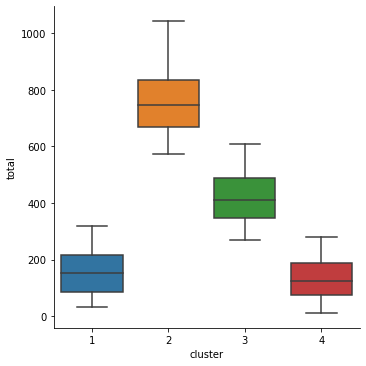

In [66]:
sns.catplot(x = 'cluster', y='total', kind='box',data=encoded_df)
plt.show()

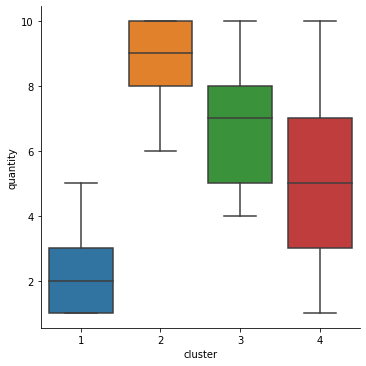

In [67]:
sns.catplot(x = 'cluster', y='quantity', kind='box',data=encoded_df)
plt.show()

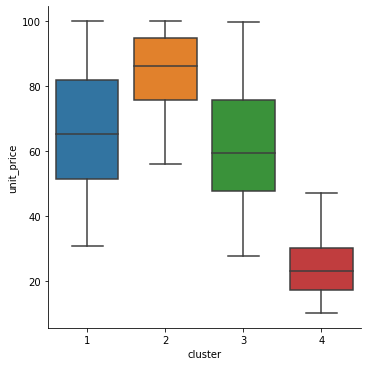

In [68]:
sns.catplot(x = 'cluster', y='unit_price', kind='box',data=encoded_df)
plt.show()

Although the interia or sum of squared error graph did not suggest that we should use 4 clusters, clustering the customers into 4 segments provided us with more insight into the types of customers at the supercenter than using 2 clusters did.